In [1]:
!pip install plotly

In [2]:
conda install -c conda-forge python-kaleido

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Gets data from respective csv files, removes any "Statewide Unallocated" data from county name from all files.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from datetime import datetime
import plotly.express as px
import numpy as np
pd.set_option('display.max_rows', 50)

cases = pd.read_csv("../../../../data/new_covid_confirmed_usafacts.csv")
deaths = pd.read_csv("../../../../data/new_covid_deaths_usafacts.csv")
pop = pd.read_csv("../../../../data/new_covid_county_population_usafacts.csv")

cases = cases[cases['County Name'] != 'Statewide Unallocated']
deaths = deaths[deaths['County Name'] != 'Statewide Unallocated']

pop = pop[pop['County Name'] != 'Statewide Unallocated']
pop = pop.drop(columns = ['County Name'])

Merges data from all files and makes the dates into a column that will later be used to group the covid cases and deaths.

In [4]:
deathsandpop = pd.merge(deaths, pop, on = ['countyFIPS', 'State'])
deathsandpop2 = pd.melt(deathsandpop, id_vars=['countyFIPS','State','County Name','StateFIPS','population'],var_name='Date', value_name='Deaths')
cases_long = pd.melt(cases, id_vars=['countyFIPS','State','County Name','StateFIPS'], var_name='Date', value_name='Cases')
alldata = pd.merge(deathsandpop2,cases_long, on=['countyFIPS','State','County Name','StateFIPS', 'Date'])

Removes date column to change it into a date_Time type. Values are then sorted by date and county FIP.

In [5]:
separateddatecol = pd.DataFrame(pd.to_datetime(alldata['Date']))
alldatanodate = pd.DataFrame(alldata.drop(columns = ['Date']))
updated = pd.concat([separateddatecol.reset_index(drop=True),alldatanodate.reset_index(drop=True)], axis = 1). fillna(0)
updated = updated.sort_values(by=['countyFIPS', 'Date'])

Calculates new cases and deaths per day by finding the difference between the number of cases on one date and the cases of that date's predecessor. They are put into their own columns in the "updated" table.

In [6]:
updated['New_Cases_Per_Day'] = updated.groupby('countyFIPS').Cases.diff()
updated['New_Deaths_Per_Day'] = updated.groupby('countyFIPS').Deaths.diff()
updated['New_Cases_Per_Day'] = np.where(updated['New_Cases_Per_Day'] < 0, 0, updated['New_Cases_Per_Day'])
updated['New_Deaths_Per_Day'] = np.where(updated['New_Deaths_Per_Day'] < 0, 0, updated['New_Deaths_Per_Day'])

Finds only data for the state of New York and groups it by week. Normalized per 10000.

In [7]:
nyData = updated.loc[updated['State'] == 'NY']
weeklynyData = nyData.groupby([pd.Grouper(key='Date', freq='1w'), 'County Name' , 'population'])['New_Cases_Per_Day','New_Deaths_Per_Day'].agg({'New_Cases_Per_Day':'mean','New_Deaths_Per_Day' :'mean'}).reset_index().round(decimals=0)
weeklynyData['Normalized_Cases_Per_Day'] = (weeklynyData['New_Cases_Per_Day']/weeklynyData['population']) * 10000
weeklynyData['Normalized_Deaths_Per_Day'] = (weeklynyData['New_Deaths_Per_Day']/weeklynyData['population']) * 10000

### Weekly case statistics:

In [8]:
ny_mean_cases = weeklynyData['New_Cases_Per_Day'].mean()
ny_median_cases = weeklynyData['New_Cases_Per_Day'].median()
ny_mode_cases = weeklynyData['New_Cases_Per_Day'].mode()

print('Weekly Cases Mean: ', ny_mean_cases)
print('Weekly Cases Median: ', ny_median_cases)
print('Weekly Cases Mode: ', ny_mode_cases)

Weekly Cases Mean:  62.657995143947275
Weekly Cases Median:  9.0
Weekly Cases Mode:  0    0.0
dtype: float64


### Weekly death statistics:

In [9]:
ny_mean_deaths = weeklynyData['New_Deaths_Per_Day'].mean()
ny_median_deaths = weeklynyData['New_Deaths_Per_Day'].median()
ny_mode_deaths = weeklynyData['New_Deaths_Per_Day'].mode()

print('Weekly Deaths Mean: ', ny_mean_deaths)
print('Weekly Deaths Median: ', ny_median_deaths)
print('Weekly Deaths Mode: ', ny_mode_deaths)

Weekly Deaths Mean:  1.357613596947624
Weekly Deaths Median:  0.0
Weekly Deaths Mode:  0    0.0
dtype: float64


### Compare data to other states. These states are Alaska, California, Florida, Georgia and Nevada.

In [10]:
statesData = updated[updated['State'].isin(['AL','CA','FL','GA','NE', 'NY'])].reset_index(drop=True)
statesDatabyweek = statesData.groupby([pd.Grouper(key='Date', freq='1w') , 'State','County Name' , 'population'])['New_Cases_Per_Day','New_Deaths_Per_Day'].agg({'New_Cases_Per_Day':'mean','New_Deaths_Per_Day' :'mean'}).reset_index().round(decimals=0)

statesDatabyweek['Normalized_Cases_Per_Day'] = (statesDatabyweek['New_Cases_Per_Day']/statesDatabyweek['population']) * 10000
statesDatabyweek['Normalized_Deaths_Per_Day'] = (statesDatabyweek['New_Deaths_Per_Day']/statesDatabyweek['population']) * 10000

statesData['Normalized_Cases_Per_Day'] = (statesData['New_Cases_Per_Day']/statesData['population']) * 10000
statesData['Normalized_Deaths_Per_Day'] = (statesData['New_Deaths_Per_Day']/statesData['population']) * 10000
statesDatabyweek

,Date,State,County Name,population,New_Cases_Per_Day,New_Deaths_Per_Day,Normalized_Cases_Per_Day,Normalized_Deaths_Per_Day
0,2020-01-26,AL,Autauga County,55869,0.0,0.0,0.000000,0.000000
1,2020-01-26,AL,Baldwin County,223234,0.0,0.0,0.000000,0.000000
2,2020-01-26,AL,Barbour County,24686,0.0,0.0,0.000000,0.000000
3,2020-01-26,AL,Bibb County,22394,0.0,0.0,0.000000,0.000000
4,2020-01-26,AL,Blount County,57826,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
47053,2021-10-31,NY,Washington County,61204,22.0,0.0,3.594536,0.000000
47054,2021-10-31,NY,Wayne County,89918,25.0,2.0,2.780311,0.222425
47055,2021-10-31,NY,Westchester County,967506,68.0,3.0,0.702838,0.031008
47056,2021-10-31,NY,Wyoming County,39859,4.0,0.0,1.003537,0.000000


In [11]:
statesdates = pd.DataFrame(pd.to_datetime(statesData['Date']))
statesData = pd.DataFrame(statesData.drop(columns=['Date']))
statesData = pd.concat([statesdates.reset_index(drop=True),statesData.reset_index(drop=True)], axis=1).fillna(0)

Compare using a graph.

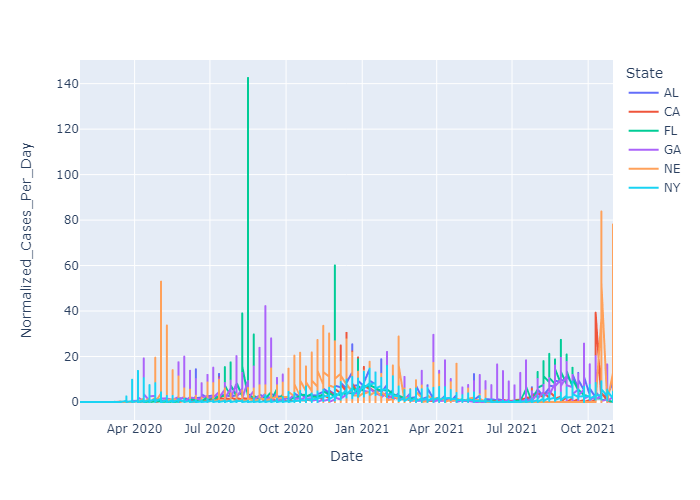

In [12]:
states_plot = px.line(statesDatabyweek, x ='Date', y='Normalized_Cases_Per_Day', color='State')
states_plot.show("png")

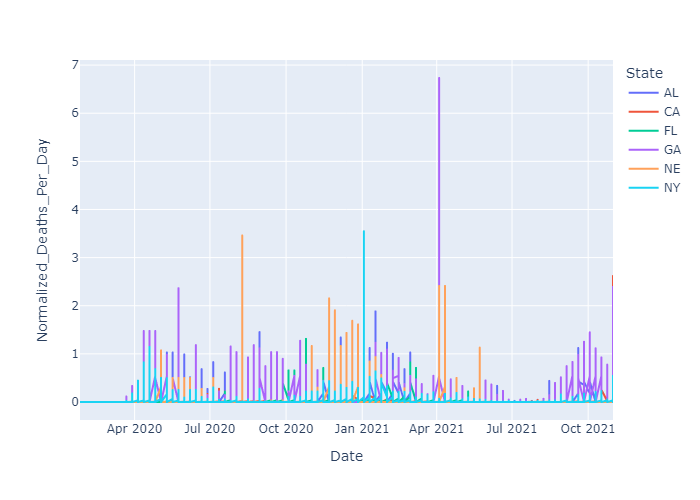

In [27]:
states_plot = px.line(statesDatabyweek, x ='Date', y='Normalized_Deaths_Per_Day', color='State')
states_plot.show("png")

### Indentify counties within New York with high case and death rates.

In [13]:
nyData2 = statesData.loc[statesData['State'] == 'NY']

topFivecounties = nyData2.groupby(nyData2['County Name'])['Normalized_Cases_Per_Day','Normalized_Deaths_Per_Day'].max()
topFivecounties = topFivecounties.nlargest(5,['Normalized_Cases_Per_Day','Normalized_Deaths_Per_Day'])
topFivecounties

,Normalized_Cases_Per_Day,Normalized_Deaths_Per_Day
County Name,,
Hamilton County,49.818841,2.264493
Herkimer County,33.920971,0.815408
Lewis County,31.944022,1.140858
Genesee County,30.900838,1.396648
Rockland County,30.694713,1.442652


Hamilton, Herkimer, Lewis, Genesee, and Rockland counties are the most infected counties in NY.

### Plotted daily trends of NY.

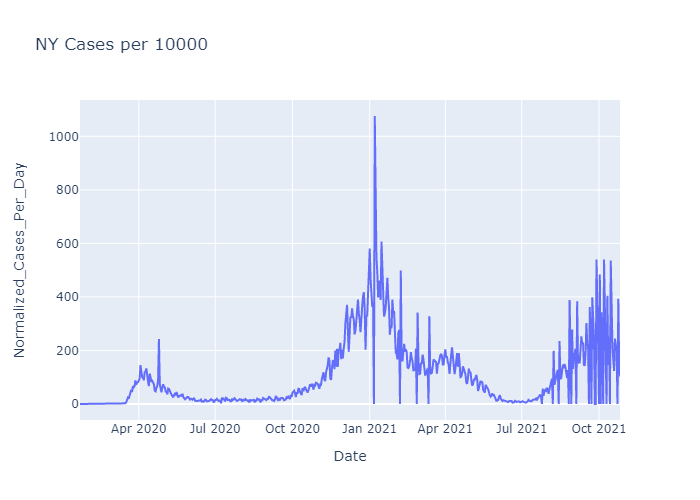

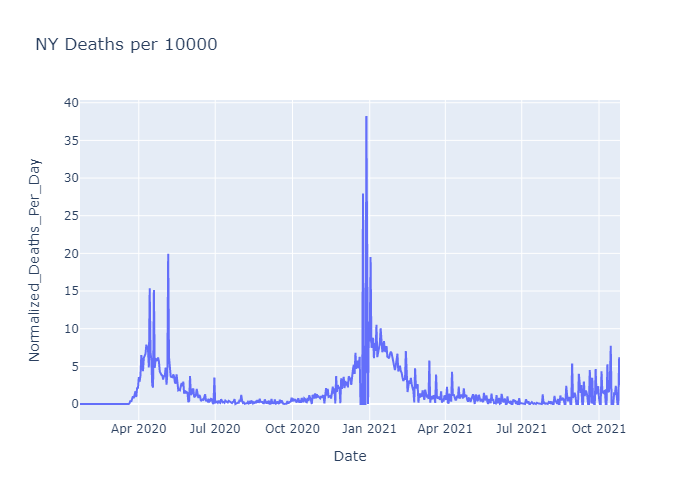

In [14]:
groupednydata = nyData2.groupby(['Date'])['Normalized_Cases_Per_Day','Normalized_Deaths_Per_Day'].sum()
groupednydata['date'] = groupednydata.index
fig = px.line(groupednydata, x=groupednydata.index, y="Normalized_Cases_Per_Day", title='NY Cases per 10000')
fig.show("png")
fig2 = px.line(groupednydata, x=groupednydata.index, y="Normalized_Deaths_Per_Day", title='NY Deaths per 10000')
fig2.show("png")

#### log normalized values

C:\Users\sytiv\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



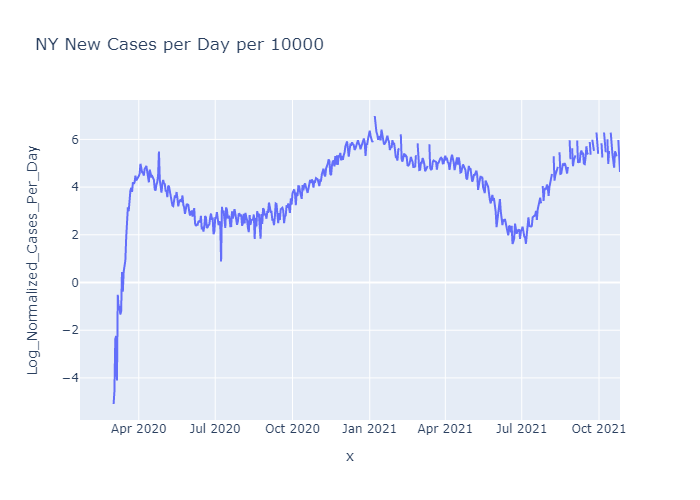

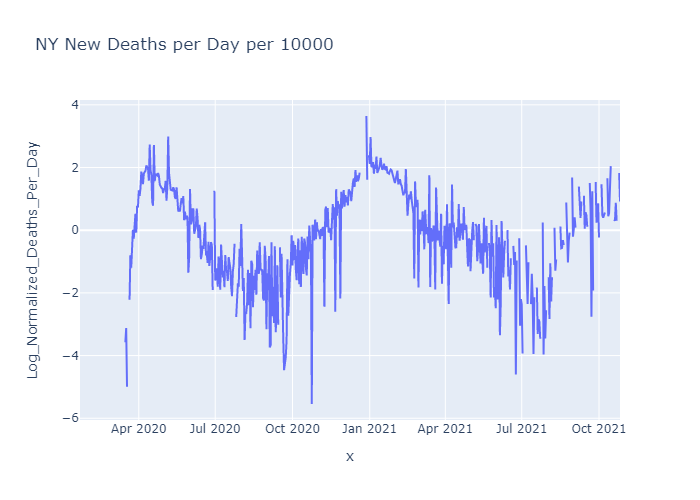

In [15]:
logcasesanddeaths = pd.DataFrame()
logcasesanddeaths['date'] = groupednydata['date']
logcasesanddeaths['Log_Normalized_Cases_Per_Day'] = np.log(groupednydata['Normalized_Cases_Per_Day'])
logcasesanddeaths['Log_Normalized_Deaths_Per_Day'] = np.log(groupednydata['Normalized_Deaths_Per_Day'])

log_cases = px.line(logcasesanddeaths, x=groupednydata.index, y="Log_Normalized_Cases_Per_Day", title='NY New Cases per Day per 10000')
log_cases.show("png")
log_deaths = px.line(logcasesanddeaths, x=groupednydata.index, y="Log_Normalized_Deaths_Per_Day", title='NY New Deaths per Day per 10000')
log_deaths.show("png")

### Plotted daily trends of the top 5 infected counties.

In [16]:
Hamilton = nyData2.loc[nyData2['County Name'].str.contains(pat = 'Hamilton County')]
Herkimer = nyData2.loc[nyData2['County Name'].str.contains(pat = 'Herkimer County')]
Lewis = nyData2.loc[nyData2['County Name'].str.contains(pat = 'Lewis County')]
Genesee = nyData2.loc[nyData2['County Name'].str.contains(pat = 'Genesee County')]
Rockland =nyData2.loc[nyData2['County Name'].str.contains(pat = 'Rockland County')]

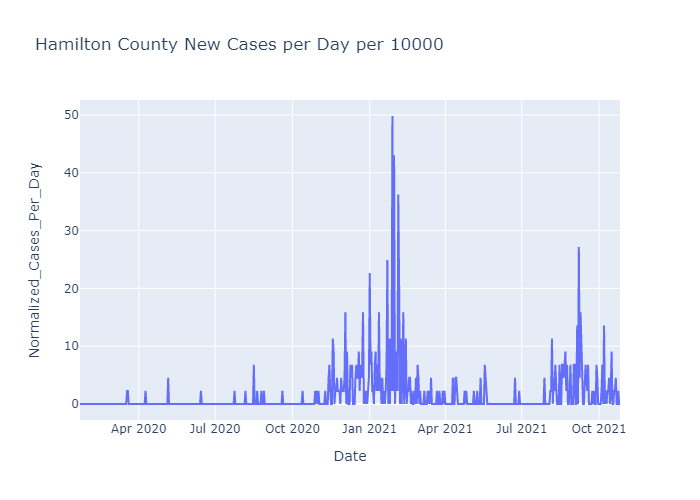

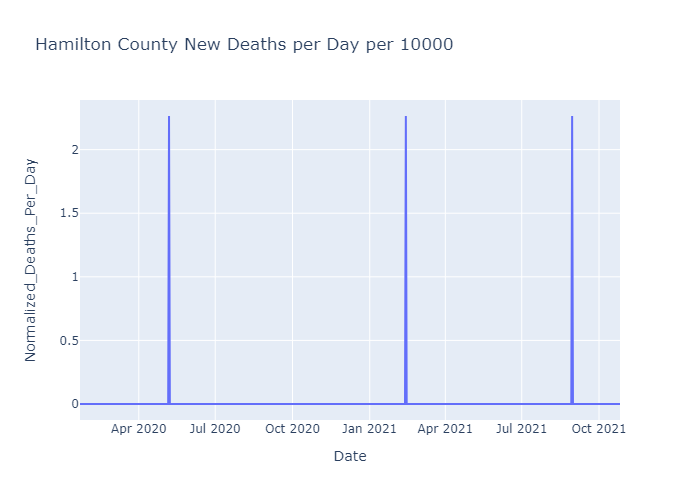

In [17]:
Hamgroup =Hamilton.groupby(['Date'])['Normalized_Cases_Per_Day','Normalized_Deaths_Per_Day'].sum()
Hamfig = px.line(Hamgroup, x=Hamgroup.index, y="Normalized_Cases_Per_Day", title='Hamilton County New Cases per Day per 10000')
Hamfig.show("png")
Hamfig2 = px.line(Hamgroup, x=Hamgroup.index, y="Normalized_Deaths_Per_Day", title='Hamilton County New Deaths per Day per 10000')
Hamfig2.show("png")

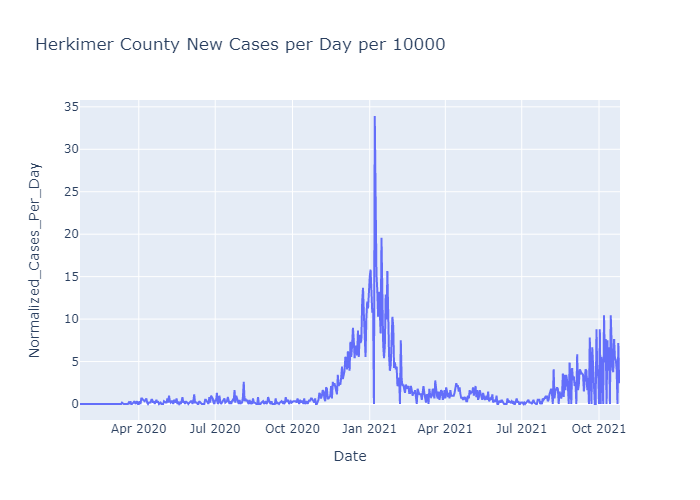

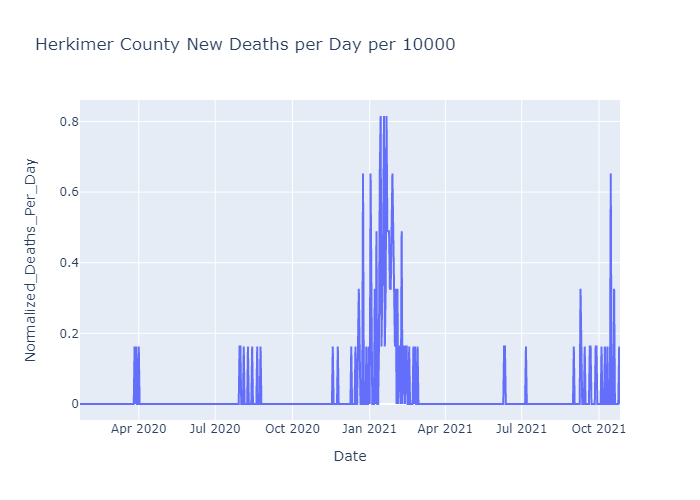

In [18]:
Herkgroup =Herkimer.groupby(['Date'])['Normalized_Cases_Per_Day','Normalized_Deaths_Per_Day'].sum()
Herkfig = px.line(Herkgroup, x=Herkgroup.index, y="Normalized_Cases_Per_Day", title='Herkimer County New Cases per Day per 10000')
Herkfig.show("png")
Herkfig2 = px.line(Herkgroup, x=Herkgroup.index, y="Normalized_Deaths_Per_Day", title='Herkimer County New Deaths per Day per 10000')
Herkfig2.show("png")

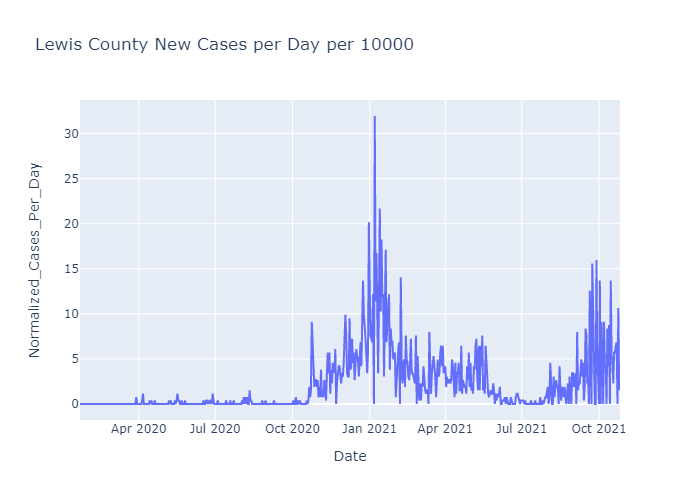

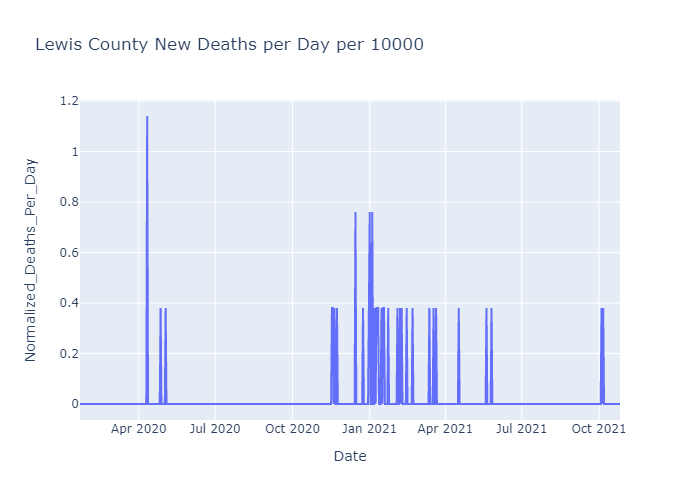

In [19]:
Lewgroup =Lewis.groupby(['Date'])['Normalized_Cases_Per_Day','Normalized_Deaths_Per_Day'].sum()
Lewfig = px.line(Lewgroup, x=Lewgroup.index, y="Normalized_Cases_Per_Day", title='Lewis County New Cases per Day per 10000')
Lewfig.show("png")
Lewfig2 = px.line(Lewgroup, x=Lewgroup.index, y="Normalized_Deaths_Per_Day", title='Lewis County New Deaths per Day per 10000')
Lewfig2.show("png")

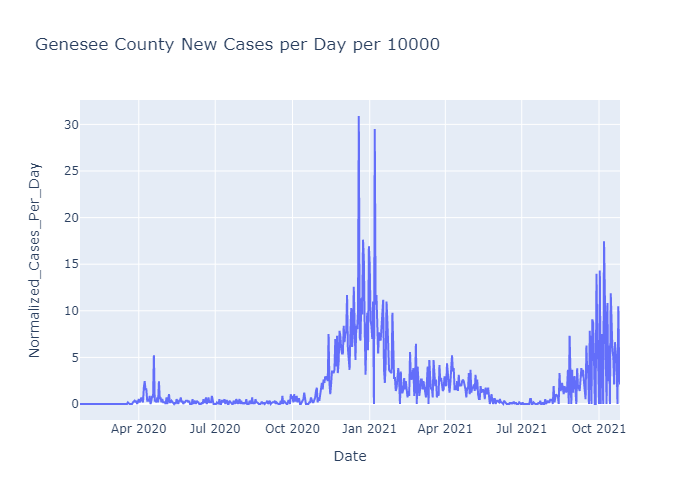

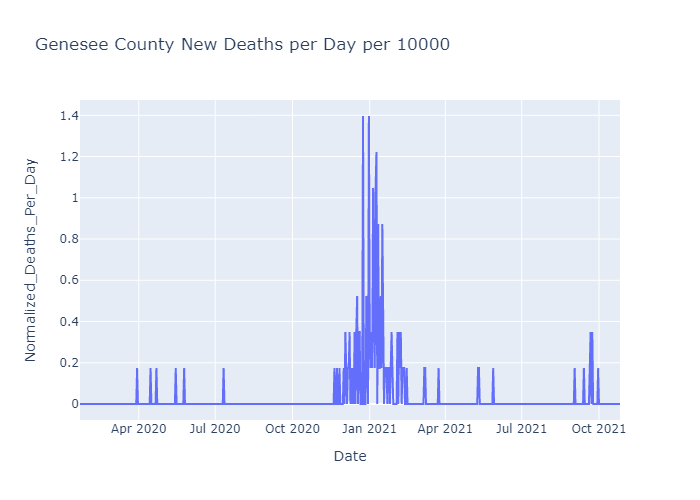

In [20]:
Gengroup =Genesee.groupby(['Date'])['Normalized_Cases_Per_Day','Normalized_Deaths_Per_Day'].sum()
Genfig = px.line(Gengroup, x=Gengroup.index, y="Normalized_Cases_Per_Day", title='Genesee County New Cases per Day per 10000')
Genfig.show("png")
Genfig2 = px.line(Gengroup, x=Gengroup.index, y="Normalized_Deaths_Per_Day", title='Genesee County New Deaths per Day per 10000')
Genfig2.show("png")

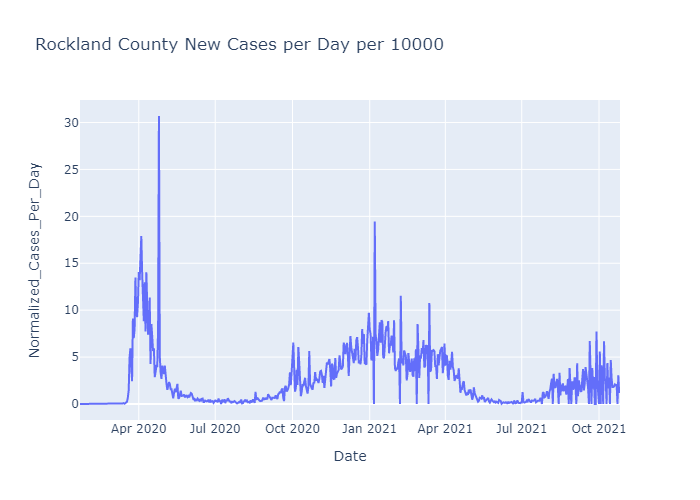

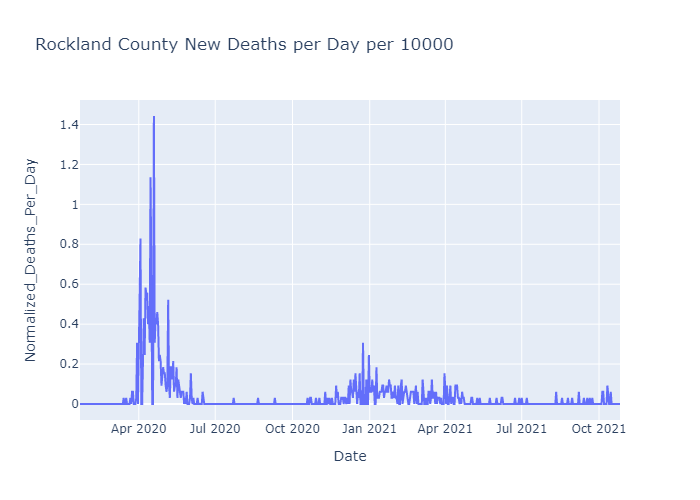

In [21]:
Rockgroup =Rockland.groupby(['Date'])['Normalized_Cases_Per_Day','Normalized_Deaths_Per_Day'].sum()
Rockfig = px.line(Rockgroup, x=Rockgroup.index, y="Normalized_Cases_Per_Day", title='Rockland County New Cases per Day per 10000')
Rockfig.show("png")
Rockfig2 = px.line(Rockgroup, x=Rockgroup.index, y="Normalized_Deaths_Per_Day", title='Rockland County New Deaths per Day per 10000')
Rockfig2.show("png")

County Log normalized values

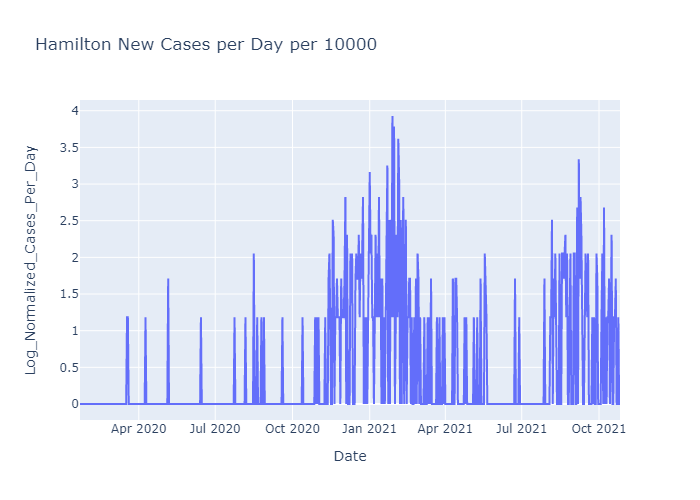

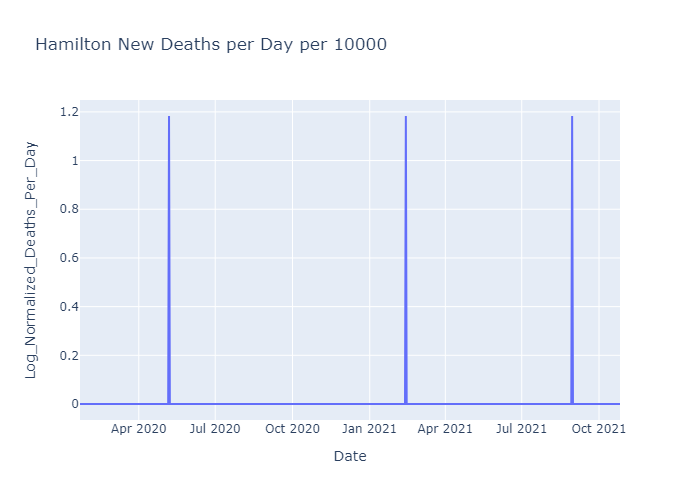

In [22]:
Hamlog = pd.DataFrame(Hamgroup)
Hamlog['Log_Normalized_Cases_Per_Day'] = np.log(Hamgroup['Normalized_Cases_Per_Day'] +1)
Hamlog['Log_Normalized_Deaths_Per_Day'] = np.log(Hamgroup['Normalized_Deaths_Per_Day'] +1)


hamlog_cases = px.line(Hamlog, x=Hamlog.index, y="Log_Normalized_Cases_Per_Day", title='Hamilton New Cases per Day per 10000')
hamlog_cases.show("png")
hamlog_deaths = px.line(Hamlog, x=Hamlog.index, y="Log_Normalized_Deaths_Per_Day", title='Hamilton New Deaths per Day per 10000')
hamlog_deaths.show("png")

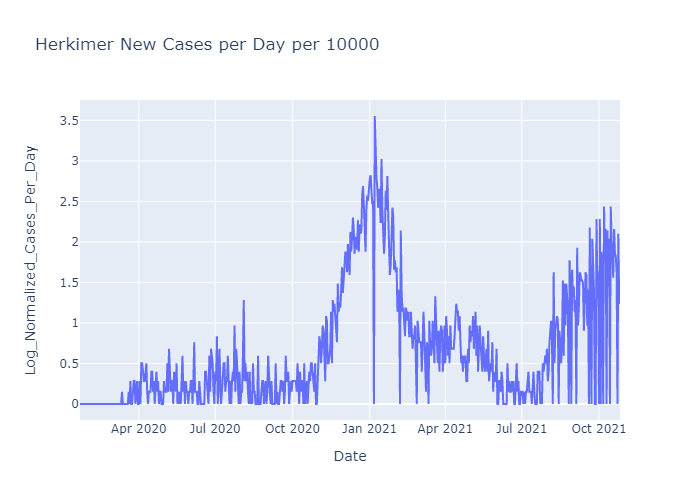

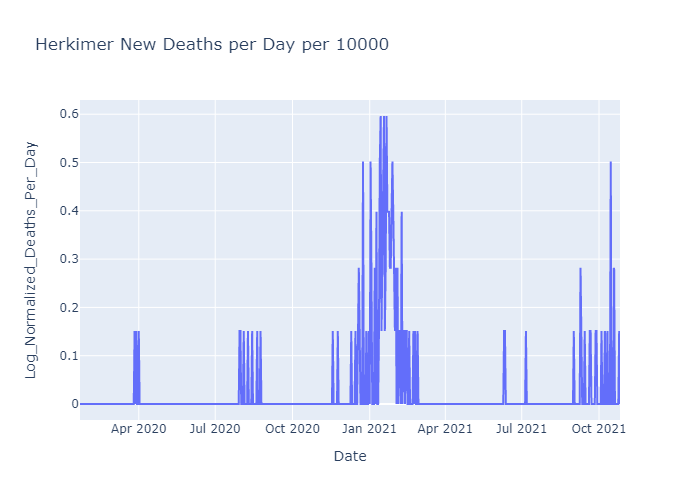

In [23]:
Herklog = pd.DataFrame(Herkgroup)
Herklog['Log_Normalized_Cases_Per_Day'] = np.log(Herkgroup['Normalized_Cases_Per_Day'] +1)
Herklog['Log_Normalized_Deaths_Per_Day'] = np.log(Herkgroup['Normalized_Deaths_Per_Day'] +1)


herklog_cases = px.line(Herklog, x=Herklog.index, y="Log_Normalized_Cases_Per_Day", title='Herkimer New Cases per Day per 10000')
herklog_cases.show("png")
herklog_deaths = px.line(Herklog, x=Herklog.index, y="Log_Normalized_Deaths_Per_Day", title='Herkimer New Deaths per Day per 10000')
herklog_deaths.show("png")

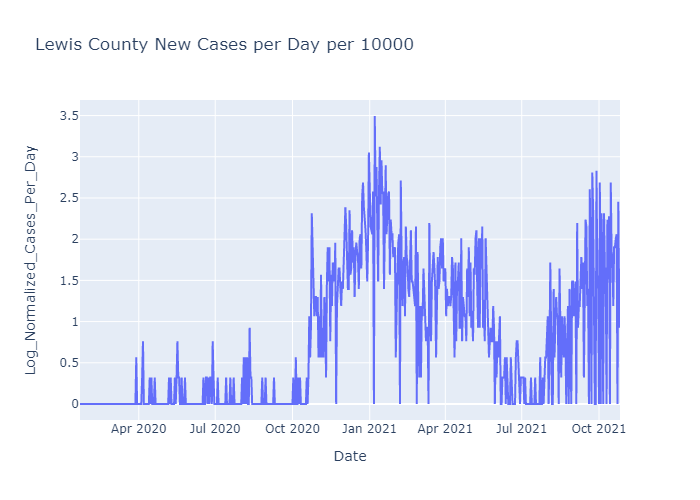

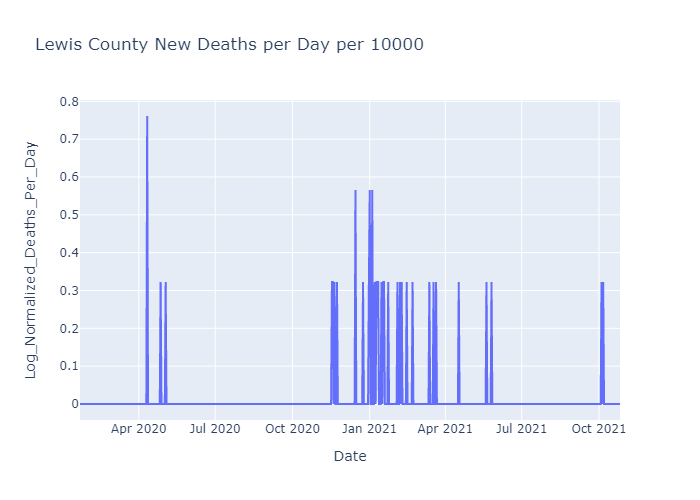

In [24]:
Lewlog = pd.DataFrame(Lewgroup)
Lewlog['Log_Normalized_Cases_Per_Day'] = np.log(Lewgroup['Normalized_Cases_Per_Day'] +1)
Lewlog['Log_Normalized_Deaths_Per_Day'] = np.log(Lewgroup['Normalized_Deaths_Per_Day'] +1)


Lewlog_cases = px.line(Lewlog, x=Lewlog.index, y="Log_Normalized_Cases_Per_Day", title='Lewis County New Cases per Day per 10000')
Lewlog_cases.show("png")
Lewlog_deaths = px.line(Lewlog, x=Lewlog.index, y="Log_Normalized_Deaths_Per_Day", title='Lewis County New Deaths per Day per 10000')
Lewlog_deaths.show("png")

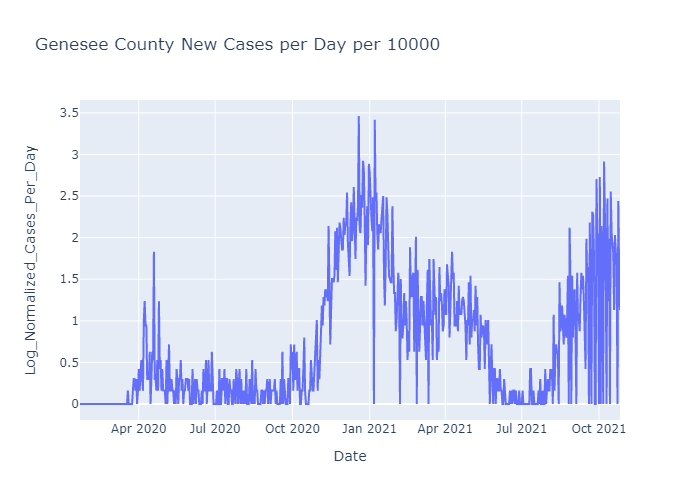

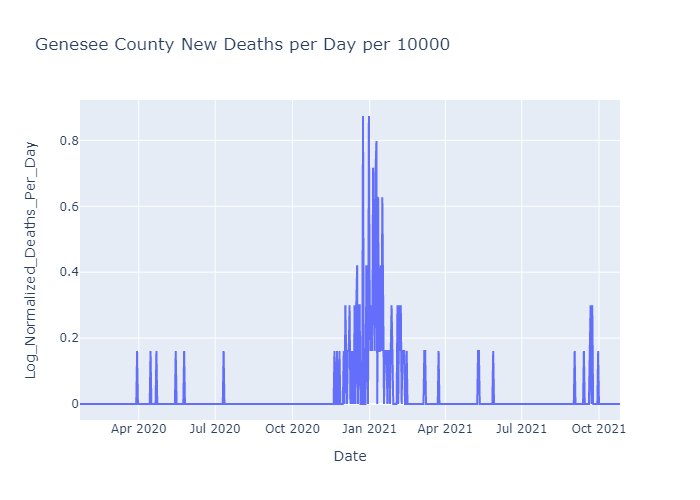

In [25]:
Genlog = pd.DataFrame(Gengroup)
Genlog['Log_Normalized_Cases_Per_Day'] = np.log(Gengroup['Normalized_Cases_Per_Day'] +1)
Genlog['Log_Normalized_Deaths_Per_Day'] = np.log(Gengroup['Normalized_Deaths_Per_Day'] +1)


Genlog_cases = px.line(Genlog, x=Genlog.index, y="Log_Normalized_Cases_Per_Day", title='Genesee County New Cases per Day per 10000')
Genlog_cases.show("png")
Genlog_deaths = px.line(Genlog, x=Genlog.index, y="Log_Normalized_Deaths_Per_Day", title='Genesee County New Deaths per Day per 10000')
Genlog_deaths.show("png")

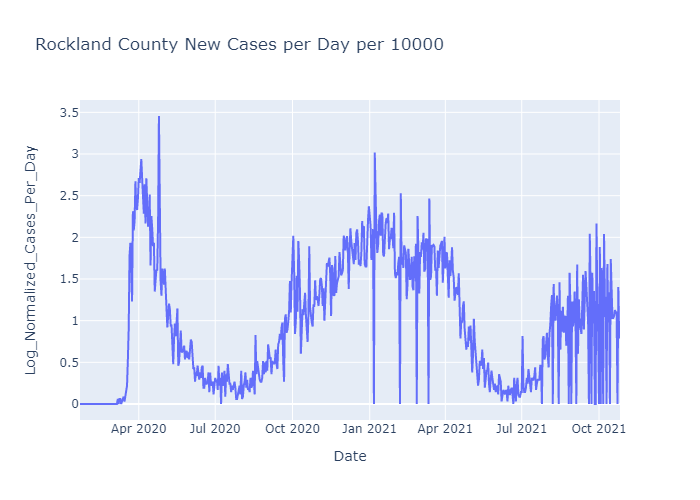

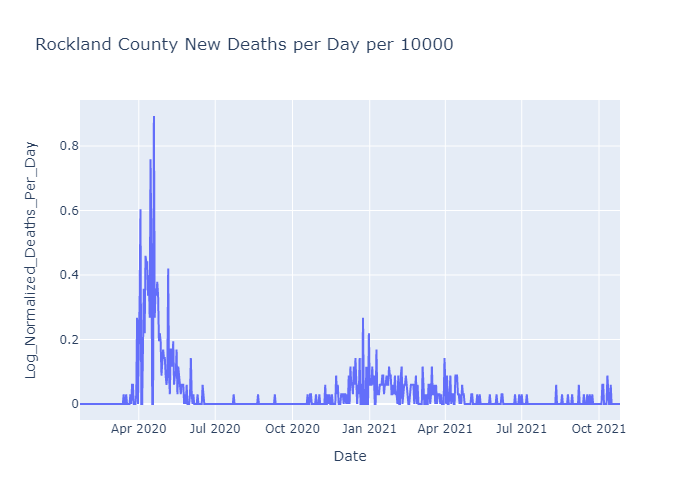

In [26]:
Rocklog = pd.DataFrame(Rockgroup)
Rocklog['Log_Normalized_Cases_Per_Day'] = np.log(Rockgroup['Normalized_Cases_Per_Day'] +1)
Rocklog['Log_Normalized_Deaths_Per_Day'] = np.log(Rockgroup['Normalized_Deaths_Per_Day'] +1)


Rocklog_cases = px.line(Rocklog, x=Rocklog.index, y="Log_Normalized_Cases_Per_Day", title='Rockland County New Cases per Day per 10000')
Rocklog_cases.show("png")
Rocklog_deaths = px.line(Rocklog, x=Rocklog.index, y="Log_Normalized_Deaths_Per_Day", title='Rockland County New Deaths per Day per 10000')
Rocklog_deaths.show("png")
